# 02 - Variography
Proposito: calcular variograma experimental, diagnosticar anisotropia y ajustar un modelo teorico reproducible.

Inputs:
- `config/project.json`
- CSV en `cfg["data_csv_path"]`

Outputs esperados:
- `outputs/figures/variogram.png`
- `outputs/figures/variogram_context.png`
- `outputs/figures/variogram_directional.png`
- `outputs/figures/variogram_residuals.png`
- `outputs/models/variogram_var.json`


### 1. Project setup

In [1]:
import os, sys, json
from datetime import datetime
from IPython.display import Image, display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir(PROJECT_ROOT)
else:
    PROJECT_ROOT = os.getcwd()
    os.chdir(PROJECT_ROOT)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CWD:", os.getcwd())

from src.preprocess import load_and_preprocess
from src.variography import experimental_variogram_2d


PROJECT_ROOT: C:\Users\joelm\Documents\geostats
CWD: C:\Users\joelm\Documents\geostats


### 2. Load config

In [2]:
cfg_path = "config/project.json"
print("Config:", os.path.abspath(cfg_path))
with open(cfg_path, "r", encoding="utf-8") as f:
    cfg = json.load(f)

print("Data CSV:", cfg["data_csv_path"])
mapping = {
    "x": cfg["columns"].get("x"),
    "y": cfg["columns"].get("y"),
    "z": cfg["columns"].get("z"),
    "var": cfg["columns"].get("variable_objetivo"),
}
print("Column mapping:", mapping)

# Variogram params defaults
vario_defaults = {
    "nlag": 12,
    "lag": 50.0,
    "azm": 0.0,
    "atol": 22.5,
    "bandwh": 9999.0,
}
vario_cfg = {**vario_defaults, **cfg.get("variogram", {})}
cfg["variogram"] = vario_cfg

# Variogram model config (optional)
model_defaults = {
    "type": "spherical",
    "nugget": None,
    "sill": None,
    "range": None,
    "fit": "auto",  # auto | manual
}
model_cfg = {**model_defaults, **cfg.get("variogram_model", {})}
cfg["variogram_model"] = model_cfg

print("Variogram params:", vario_cfg)
print("Variogram model cfg:", model_cfg)


Config: C:\Users\joelm\Documents\geostats\config\project.json
Data CSV: csv/Conminution.csv
Column mapping: {'x': 'X', 'y': 'Y', 'z': 'Z', 'var': 'Bwi_kWh_t'}
Variogram params: {'nlag': 12, 'lag': 50.0, 'azm': 0.0, 'atol': 22.5, 'bandwh': 9999.0, 'dip': 0.0, 'dtol': 22.5, 'bandwd': 9999.0}
Variogram model cfg: {'type': 'spherical', 'nugget': None, 'sill': None, 'range': None, 'fit': 'auto'}


### 3. Load data y escala espacial
Se asume que las coordenadas estan en **metros** si los rangos lo sugieren.
Se reporta la escala espacial del dataset para contextualizar el rango del variograma.


In [3]:
df, df_raw, mapping = load_and_preprocess(cfg)

rows_before = len(df_raw)
rows_after = len(df)
removed_pct = 0.0 if rows_before == 0 else (rows_before - rows_after) * 100.0 / rows_before

print("Shape raw:", df_raw.shape, "clean:", df.shape)
print("Dtypes:\n", df.dtypes)
print("Rows removed (%):", f"{removed_pct:.2f}")

x_min, x_max = float(df["x"].min()), float(df["x"].max())
y_min, y_max = float(df["y"].min()), float(df["y"].max())
if "z" in df.columns and df["z"].notna().any():
    z_min, z_max = float(df["z"].min()), float(df["z"].max())
else:
    z_min, z_max = (float("nan"), float("nan"))

x_rng = x_max - x_min
y_rng = y_max - y_min
z_rng = z_max - z_min if np.isfinite(z_min) and np.isfinite(z_max) else float("nan")
xy_diag = float(np.hypot(x_rng, y_rng))

print("X range:", (x_min, x_max))
print("Y range:", (y_min, y_max))
print("Z range:", (z_min, z_max) if np.isfinite(z_min) else "n/a")
print("XY diagonal (approx):", f"{xy_diag:.2f}")
print("Assumed units: meters (if coordinate ranges are metric).")

Shape raw: (600, 12) clean: (600, 12)
Dtypes:
 x             float64
y             float64
z             float64
Hole ID           str
Samples_ID        str
Lote              str
domain            str
Minz              str
EM_new            str
EM                str
var           float64
Axb_SMC       float64
dtype: object
Rows removed (%): 0.00
X range: (2363710.832, 2365405.149)
Y range: (6485685.572631, 6487146.812069)
Z range: (3104.889936, 3834.876096)
XY diagonal (approx): 2237.39
Assumed units: meters (if coordinate ranges are metric).


### 4. EDA minimo contextual
Antes de la variografia, se revisa rapidamente la distribucion y el patron espacial.
Esto ayuda a detectar outliers o tendencias claras.


In [4]:
os.makedirs("outputs/figures", exist_ok=True)

n = len(df)
max_plot = 5000
plot_df = df.sample(n=max_plot, random_state=42) if n > max_plot else df

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
sc = axes[0].scatter(
    plot_df["x"],
    plot_df["y"],
    c=plot_df["var"],
    s=18,
    cmap="viridis",
    alpha=0.65,
)
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].set_title("Mapa XY coloreado por variable")
plt.colorbar(sc, ax=axes[0], label="var")

axes[1].hist(df["var"].dropna(), bins=30, color="#4C78A8", edgecolor="white")
axes[1].set_xlabel("var")
axes[1].set_ylabel("count")
axes[1].set_title("Histograma de la variable")

plt.tight_layout()
context_path = "outputs/figures/variogram_context.png"
plt.savefig(context_path, dpi=150)
plt.close()

print("Saved:", context_path)


Saved: outputs/figures/variogram_context.png


### 5. Variograma experimental
El variograma describe como cambia la **semivarianza** con la distancia:
- **Nugget**: variabilidad a muy corta distancia (ruido o micro-escala).
- **Sill**: meseta de la semivarianza (varianza total).
- **Range**: distancia donde la semivarianza alcanza ~95% del sill (rango practico).


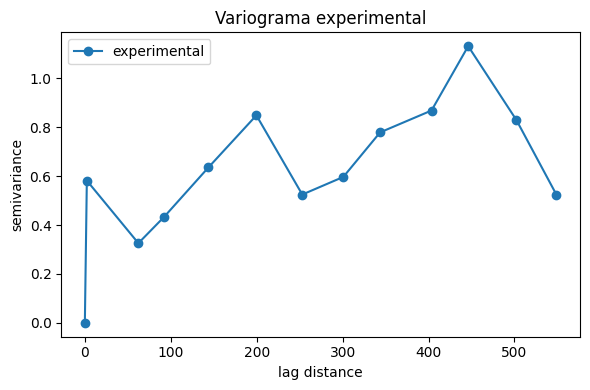

In [5]:
exp = experimental_variogram_2d(df, "x", "y", "var", cfg["variogram"])

lags = np.asarray(exp["lags"], dtype=float)
gamma = np.asarray(exp["gamma"], dtype=float)
npp = np.asarray(exp["npp"], dtype=float) if exp.get("npp") is not None else None

valid = np.isfinite(lags) & np.isfinite(gamma)
if npp is not None:
    valid &= npp > 0

lags_v = lags[valid]
gamma_v = gamma[valid]

plt.figure(figsize=(6, 4))
plt.plot(lags_v, gamma_v, "o-", label="experimental")
plt.xlabel("lag distance")
plt.ylabel("semivariance")
plt.title("Variograma experimental")
plt.legend()
plt.tight_layout()
plt.show()


### 6. Propuesta automatica de parametros iniciales
Se proponen valores iniciales razonables para guiar el ajuste:
- `nugget0` desde el primer lag (o 5-15% del sill).
- `sill0` desde la varianza o max(semivarianza).
- `range0` donde gamma alcanza ~95% del sill.


In [6]:
def initial_guesses(lags_v, gamma_v, data_variance):
    if lags_v.size == 0 or gamma_v.size == 0:
        sill0 = float(data_variance) if data_variance > 0 else 1.0
        return 0.1 * sill0, sill0, 1.0

    order = np.argsort(lags_v)
    lags_s = lags_v[order]
    gamma_s = gamma_v[order]

    gamma_max = float(np.nanmax(gamma_s)) if np.isfinite(np.nanmax(gamma_s)) else 0.0
    sill0 = float(data_variance) if data_variance > 0 else gamma_max
    sill0 = max(sill0, gamma_max, 1e-6)

    nugget0 = float(gamma_s[0]) if np.isfinite(gamma_s[0]) else 0.1 * sill0
    if nugget0 <= 0:
        nugget0 = 0.1 * sill0

    target = 0.95 * sill0
    range0 = float(lags_s[-1])
    idx = np.where(gamma_s >= target)[0]
    if idx.size > 0:
        range0 = float(lags_s[idx[0]])
    if range0 <= 0:
        range0 = float(lags_s[-1]) if lags_s.size > 0 else 1.0

    return nugget0, sill0, range0

var_variance = float(df["var"].var(ddof=1))
ng0, s0, r0 = initial_guesses(lags_v, gamma_v, var_variance)
print("Initial guesses -> nugget0:", f"{ng0:.4f}", "sill0:", f"{s0:.4f}", "range0:", f"{r0:.4f}")


Initial guesses -> nugget0: 1.1169 sill0: 11.1695 range0: 548.8718


### 7. Ajuste del modelo teorico
Modelos soportados: **spherical**, **exponential**, **gaussian**.
- Spherical: adecuado para estructuras con meseta clara.
- Exponential: crecimiento suave, rango practico ~ 3a.
- Gaussian: muy suave cerca del origen.

El ajuste automatico usa minimos cuadrados ponderados. Si hay `npp`, se usa como peso.


In [7]:
def _model_spherical(h, nugget, sill, vrange):
    h = np.asarray(h, dtype=float)
    hr = np.clip(h / max(vrange, 1e-9), 0.0, np.inf)
    gam = np.where(
        h <= vrange,
        nugget + (sill - nugget) * (1.5 * hr - 0.5 * hr ** 3),
        sill,
    )
    return gam


def _model_exponential(h, nugget, sill, vrange):
    h = np.asarray(h, dtype=float)
    return nugget + (sill - nugget) * (1.0 - np.exp(-3.0 * h / max(vrange, 1e-9)))


def _model_gaussian(h, nugget, sill, vrange):
    h = np.asarray(h, dtype=float)
    return nugget + (sill - nugget) * (1.0 - np.exp(-3.0 * (h / max(vrange, 1e-9)) ** 2))


def _get_model_func(model_type):
    m = model_type.lower()
    if m == "exponential":
        return _model_exponential
    if m == "gaussian":
        return _model_gaussian
    return _model_spherical


def fit_variogram_model_auto(lags_v, gamma_v, npp_v, model_type, p0):
    if lags_v.size == 0:
        return p0

    w = None
    if npp_v is not None and np.any(npp_v > 0):
        w = np.asarray(npp_v, dtype=float)
    else:
        w = 1.0 / np.maximum(lags_v, 1e-6)

    w = np.where(np.isfinite(w), w, 1.0)
    w = np.clip(w, 1e-12, np.inf)
    w = w / np.max(w)

    max_lag = float(np.nanmax(lags_v)) if lags_v.size else 1.0
    max_gamma = float(np.nanmax(gamma_v)) if gamma_v.size else 1.0

    sill_upper = max(max_gamma, var_variance, p0[1]) * 3.0
    range_upper = max_lag * 3.0 if max_lag > 0 else 1.0

    bounds = (
        [0.0, 0.0, 1e-6],
        [sill_upper, sill_upper, range_upper],
    )

    model_func = _get_model_func(model_type)
    sigma = 1.0 / np.sqrt(w)

    try:
        popt, _ = curve_fit(
            model_func,
            lags_v,
            gamma_v,
            p0=p0,
            bounds=bounds,
            sigma=sigma,
            absolute_sigma=False,
            maxfev=20000,
        )
        return popt
    except Exception as exc:
        print("Auto-fit failed, using initial guesses. Error:", exc)
        return p0


def build_geostatspy_model(model_type, nugget, sill, vrange, azm=0.0):
    it_map = {"spherical": 1, "exponential": 2, "gaussian": 3}
    it1 = it_map.get(model_type.lower(), 1)
    cc1 = max(sill - nugget, 0.0)
    hmaj = max(vrange, 1e-6)
    return {
        "nst": 1,
        "nug": float(nugget),
        "cc1": float(cc1),
        "it1": int(it1),
        "azi1": float(azm),
        "hmaj1": float(hmaj),
        "hmin1": float(hmaj),
        "cc2": 0.0,
        "it2": 1,
        "azi2": 0.0,
        "hmaj2": float(hmaj),
        "hmin2": float(hmaj),
    }

model_type = cfg["variogram_model"]["type"]
fit_method = cfg["variogram_model"].get("fit", "auto").lower()

if fit_method == "manual":
    nugget = cfg["variogram_model"].get("nugget", ng0)
    sill = cfg["variogram_model"].get("sill", s0)
    vrange = cfg["variogram_model"].get("range", r0)
    nugget = ng0 if nugget is None else float(nugget)
    sill = s0 if sill is None else float(sill)
    vrange = r0 if vrange is None else float(vrange)
else:
    p0 = (ng0, s0, r0)
    npp_v = npp[valid] if npp is not None else None
    nugget, sill, vrange = fit_variogram_model_auto(lags_v, gamma_v, npp_v, model_type, p0)

model = build_geostatspy_model(model_type, nugget, sill, vrange, azm=cfg["variogram"].get("azm", 0.0))

print("Fitted model -> type:", model_type, "nugget:", f"{nugget:.4f}", "sill:", f"{sill:.4f}", "range:", f"{vrange:.4f}")


Fitted model -> type: spherical nugget: 0.5132 sill: 0.8171 range: 471.6197


### 8. Visualizacion y diagnostico
Se grafica el variograma con el modelo ajustado y los residuos.


In [8]:
model_func = _get_model_func(model_type)

max_lag = float(np.nanmax(lags_v)) if lags_v.size else float(cfg["variogram"].get("lag", 1.0))
h_plot = np.linspace(0.0, max_lag, 120)

plt.figure(figsize=(6, 4))
plt.plot(lags_v, gamma_v, "o", label="experimental")
plt.plot(h_plot, model_func(h_plot, nugget, sill, vrange), "-", label="model")
plt.xlabel("lag distance")
plt.ylabel("semivariance")
plt.title("Variograma experimental + modelo")
plt.legend()
plt.tight_layout()

variogram_path = "outputs/figures/variogram.png"
plt.savefig(variogram_path, dpi=150)
plt.close()
print("Saved:", variogram_path)

# Residuals
residuals = gamma_v - model_func(lags_v, nugget, sill, vrange)
rmse = float(np.sqrt(np.mean(residuals ** 2))) if residuals.size else float("nan")

plt.figure(figsize=(6, 3.5))
plt.axhline(0.0, color="gray", linewidth=1)
plt.plot(lags_v, residuals, "o")
plt.xlabel("lag distance")
plt.ylabel("gamma_exp - gamma_model")
plt.title("Residuals del ajuste (RMSE: %.4f)" % rmse)
plt.tight_layout()

residuals_path = "outputs/figures/variogram_residuals.png"
plt.savefig(residuals_path, dpi=150)
plt.close()
print("Saved:", residuals_path)


Saved: outputs/figures/variogram.png
Saved: outputs/figures/variogram_residuals.png


### 9. Variografia direccional (anisotropia)
Se calculan variogramas direccionales para 0?, 45?, 90? y 135?.
Esto ayuda a detectar anisotropia geometrica.


In [9]:
dir_azimuths = [0.0, 45.0, 90.0, 135.0]

fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)
axes = axes.ravel()

for ax, azm in zip(axes, dir_azimuths):
    params = dict(cfg["variogram"])
    params["azm"] = float(azm)
    exp_dir = experimental_variogram_2d(df, "x", "y", "var", params)

    lags_d = np.asarray(exp_dir["lags"], dtype=float)
    gamma_d = np.asarray(exp_dir["gamma"], dtype=float)
    npp_d = np.asarray(exp_dir["npp"], dtype=float)
    mask = np.isfinite(lags_d) & np.isfinite(gamma_d)
    mask &= npp_d > 0

    ax.plot(lags_d[mask], gamma_d[mask], "o-", label=f"azm {azm}?")
    ax.set_title(f"Azimut {azm}?")
    ax.set_xlabel("lag")
    ax.set_ylabel("gamma")
    ax.grid(alpha=0.2)

plt.suptitle("Variogramas direccionales")
plt.tight_layout(rect=[0, 0, 1, 0.96])

dir_path = "outputs/figures/variogram_directional.png"
plt.savefig(dir_path, dpi=150)
plt.close()
print("Saved:", dir_path)


Saved: outputs/figures/variogram_directional.png


### 10. Guardado reproducible del modelo
Se guarda el modelo con metadatos de ajuste y parametros usados.


In [10]:
os.makedirs("outputs/models", exist_ok=True)

model_payload = dict(model)
model_payload.update(
    {
        "model_type": model_type,
        "nugget": float(nugget),
        "sill": float(sill),
        "range": float(vrange),
        "fit_method": fit_method,
        "rmse": rmse,
        "timestamp": datetime.now().isoformat(timespec="seconds"),
        "variogram_params": cfg["variogram"],
    }
)

model_path = "outputs/models/variogram_var.json"
with open(model_path, "w", encoding="utf-8") as f:
    json.dump(model_payload, f, indent=2)

print("Saved:", model_path)


Saved: outputs/models/variogram_var.json


### 11. Artifacts generated

Figures: ['C:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\variogram.png', 'C:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\variogram_context.png', 'C:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\variogram_directional.png', 'C:\\Users\\joelm\\Documents\\geostats\\outputs\\figures\\variogram_residuals.png']
Tables: []
Models: ['C:\\Users\\joelm\\Documents\\geostats\\outputs\\models\\variogram_var.json']


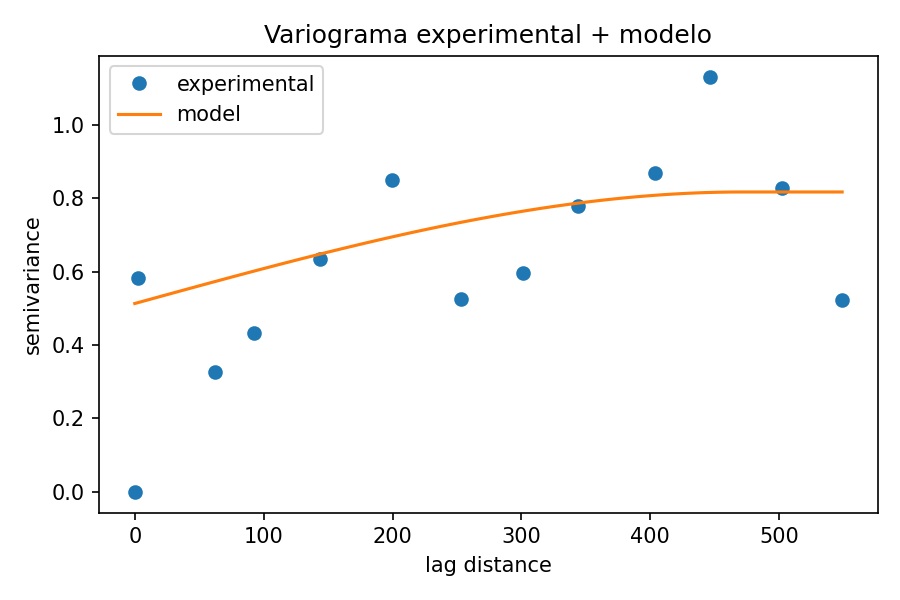

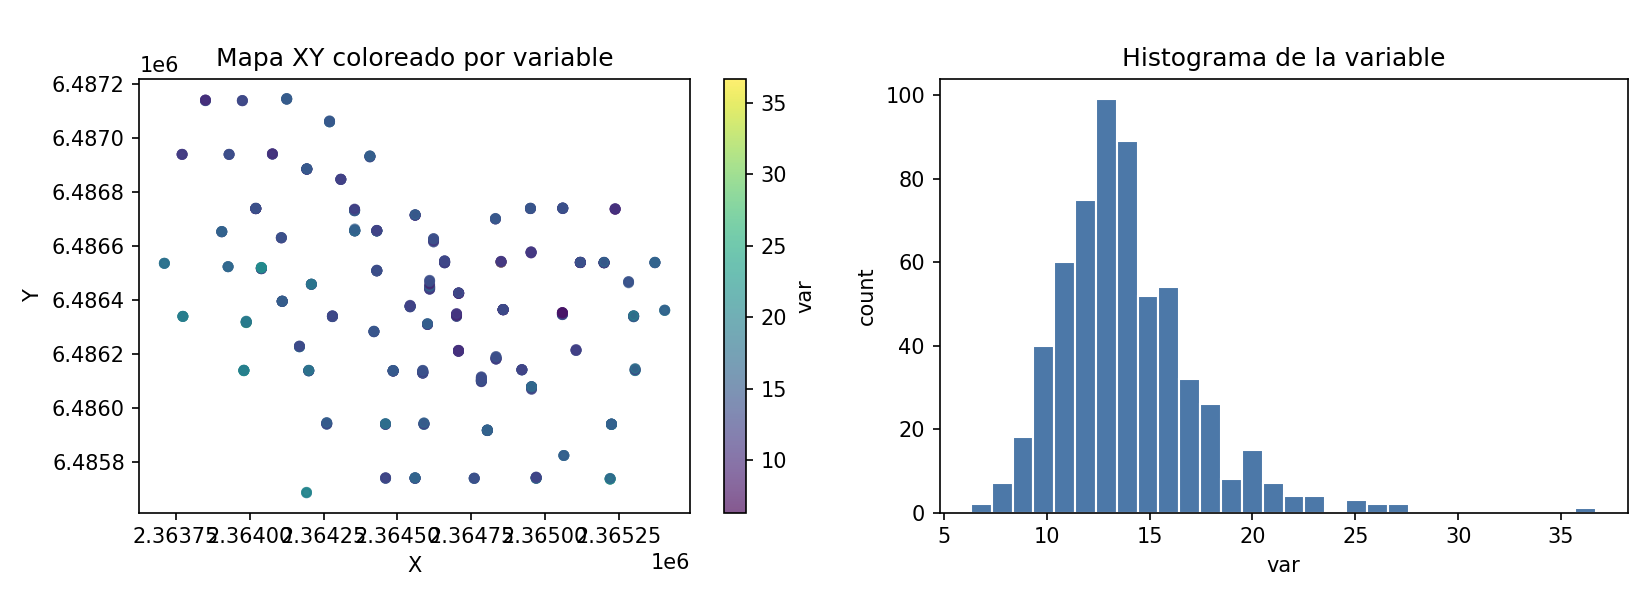

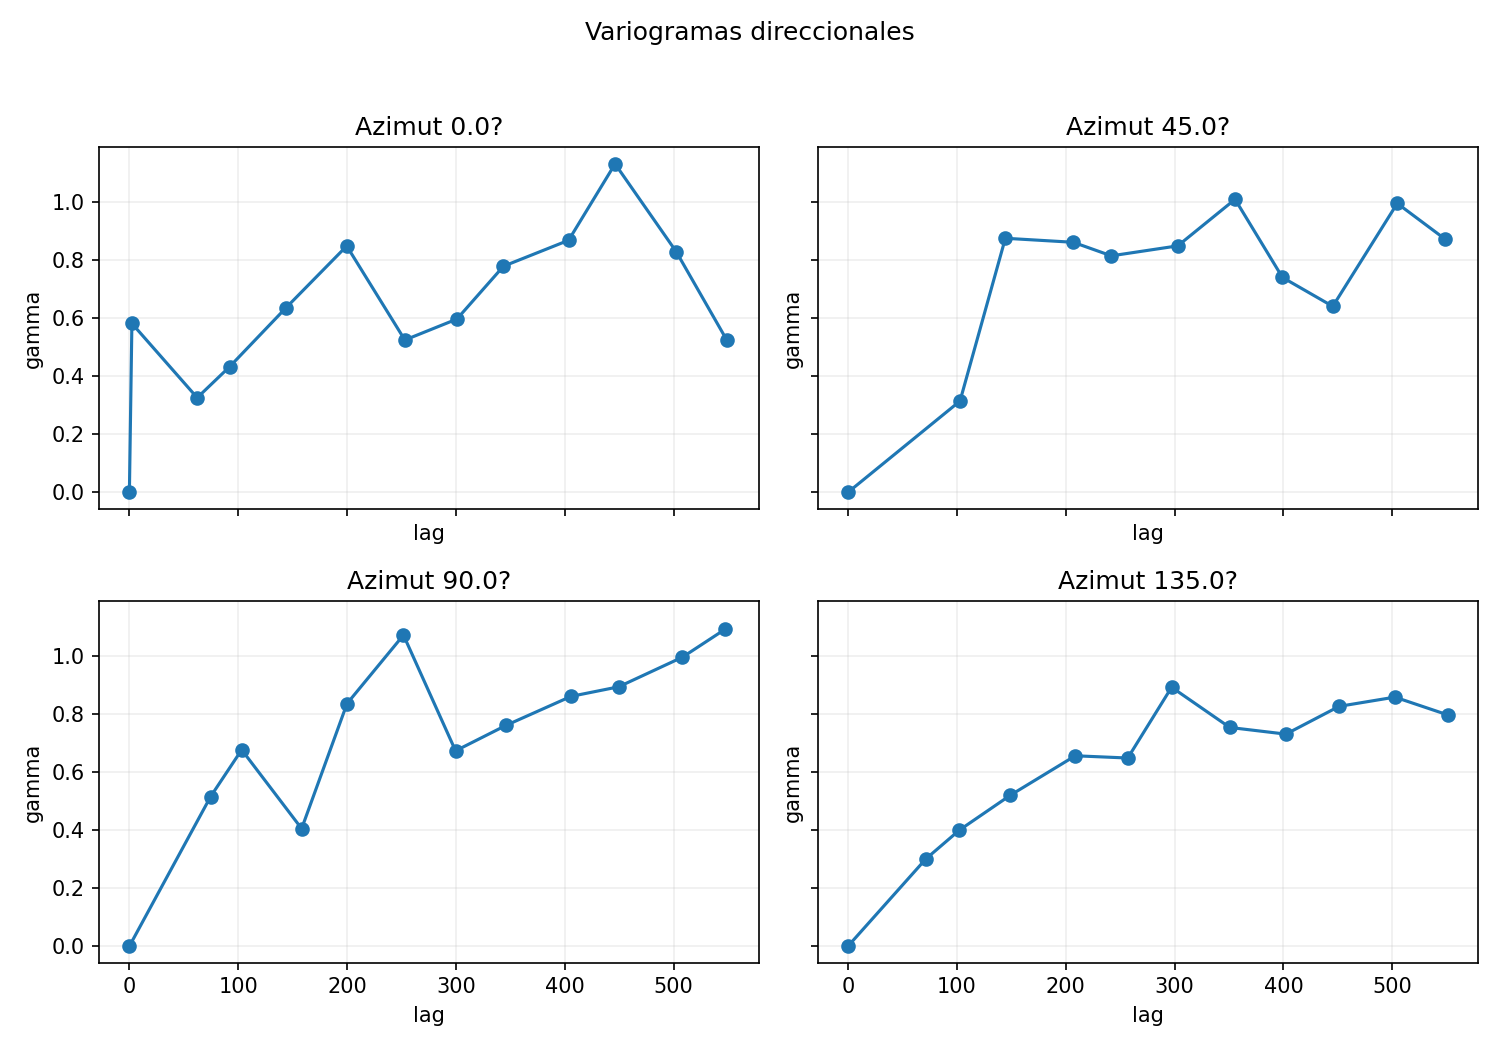

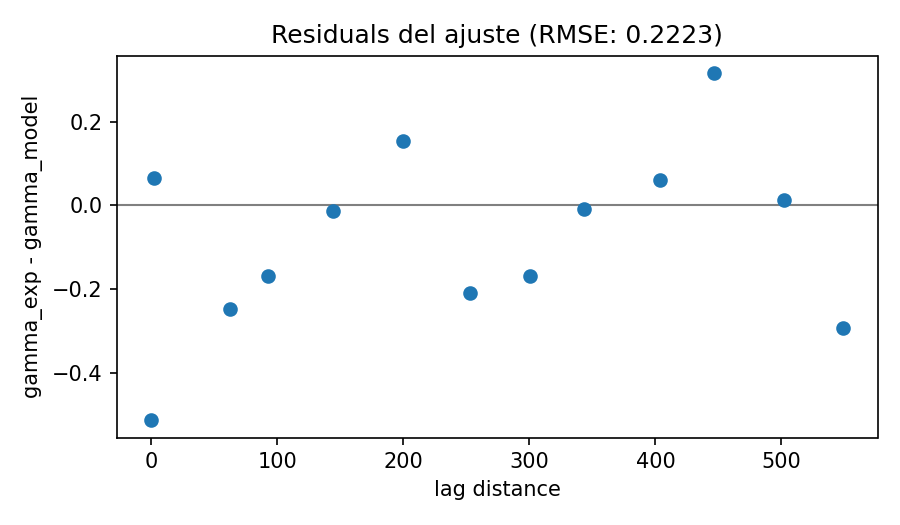

In [11]:
expected_figures = [
    "outputs/figures/variogram.png",
    "outputs/figures/variogram_context.png",
    "outputs/figures/variogram_directional.png",
    "outputs/figures/variogram_residuals.png",
]
expected_tables = []
expected_models = ["outputs/models/variogram_var.json"]

def _existing(paths):
    return [p for p in paths if os.path.exists(p)]

figure_paths = _existing(expected_figures)
table_paths = _existing(expected_tables)
model_paths = _existing(expected_models)

print("Figures:", [os.path.abspath(p) for p in figure_paths])
print("Tables:", [os.path.abspath(p) for p in table_paths])
print("Models:", [os.path.abspath(p) for p in model_paths])

for p in figure_paths:
    display(Image(filename=p))
